In [115]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl
import os
from tqdm import tqdm
import jieba
import jieba.analyse
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain
import nltk
import re

from parallel_processor import process_data
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet

import dgl.function as fn

import pickle as pkl


os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [30]:
def gc():
    import gc
    gc.collect()

# Data Processing

## Load

In [118]:
# label_names = ['government','sport','business','technology']
with open('datasets/dbpedia/label_names.txt') as fin:
    label_names = [item.replace('\n', '') for item in fin.readlines()]
label_names

['company',
 'school',
 'university',
 'artist',
 'athlete',
 'government',
 'transportation',
 'building',
 'river',
 'mountain',
 'lake',
 'village',
 'animal',
 'plant',
 'tree',
 'album',
 'film',
 'novel',
 'publication',
 'book']

In [65]:
with open('datasets/dbpedia/train.txt') as fin:
    text = [item.replace('\n', '') for item in fin.readlines()]
len(text)

560000

In [67]:
smp_idxs = np.random.randint(0, 20, len(text))
smp_idxs

array([16, 17, 10, ...,  7, 10,  8])

In [68]:
Counter(smp_idxs)

Counter({16: 27824,
         17: 28239,
         10: 28151,
         7: 27988,
         19: 27977,
         14: 27960,
         9: 28524,
         5: 27940,
         4: 27963,
         3: 28127,
         0: 27971,
         11: 27925,
         15: 28011,
         12: 27934,
         2: 27972,
         13: 28136,
         1: 27851,
         6: 28081,
         18: 27734,
         8: 27692})

In [70]:
text = [text[i] for i in range(len(smp_idxs)) if smp_idxs[i] == 0]
len(text)

27971

In [71]:
text[:4]

["JVC. Victor Company of Japan Ltd ( 日本ビクター株式会社 Nippon Bikutā Kabushiki-gaisha ) TYO: 6792 usually referred to as JVC is a Japanese international consumer and professional electronics corporation based in Yokohama Japan. Founded in 1927 the company is best known for introducing Japan's first televisions and for developing the Video Home System ( VHS ) video recorder. In 2008 JVC merged with Kenwood Corporation to create JVC Kenwood Holdings.",
 'Daum Communications. Daum ( Korean: 다음; KRX: 035720 ) is a web portal in South Korea like Naver and Nate. Daum offers many Internet services to web users including a popular free web-based e-mail messaging service forums shopping and news. The word daum is 多音 means many sounds in Korean.The popularity of Daum stems from the range of services it offers but also from the fact that it was the first Korean web portal of significant size.',
 "Lilliput Lane. Lilliput Lane founded in 1982 by David Tate is a company known for its extensive range of rea

In [38]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [39]:
text = [tokenizer.tokenize(item) for item in tqdm(text)]
text[:2]

100%|██████████| 112230/112230 [00:07<00:00, 15275.34it/s]


[['Q-workshop.',
  'Q-workshop is a Polish company located in Poznań that specializes in designand production of polyhedral dice and dice accessories for use in various games ( role-playing gamesboard games and tabletop wargames ) .',
  'They also run an online retail store and maintainan active forum community.Q-workshop was established in 2001 by Patryk Strzelewicz – a student from Poznań.',
  'Initiallythe company sold its products via online auction services but in 2005 a website and online store wereestablished.'],
 ['The Unsigned Guide.',
  'The Unsigned Guide is an online contacts directory and careers guide for the UK music industry.',
  'Founded in 2003 and first published as a printed directory The Unsigned Guide became an online only resource in November 2011.']]

In [41]:
text = list(chain.from_iterable(text))
print(len(text))
text[:4]

381118


['I-innovate ( UK ) .',
 'I-innovate ( UK ) is a London-based independent record label that diversified from video production into music management from 2009.',
 'I-innovate was founded by Najero Okenabirhie in 2008.',
 'I-innovate work with freelance directors marketers and artists in music and graphic design providing ad hoc services for clients labels and music professionals.']

* 长度check

In [72]:
lens = [len(item) for item in text]
np.min(lens), np.mean(lens), np.max(lens)

(21, 302.30574523613745, 1369)

In [73]:
long_text_idx = [i for i, l in enumerate(lens) if l > 1000]
len(long_text_idx)

5

In [74]:
[text[i] for i in long_text_idx][:2]

['Alomo Productions. Alomo Productions was a company founded in 1983 and includes with sitcoms and dramas.In 1987 till 1994 they did The New Statesman for ITV then later on BBC which stars Rik Mayall Marsha Fitzalan and Michael Troughton.In 1989 till 1998 they did Birds of a Feather for BBC which stars Pauline Quirke Linda Robson Lesley Joseph Matt Willis Charlie Quirke and Camilla Marie Beeput.In 1990 till 1993 they did Nightingales for Channel 4 which stars James Ellis Robert Lindsay and David Threlfall.In 1992 till 1994 they did Love Hurts for BBC which stars Richard Cordery Adam Faith Jane Lapotaire Tony Selby and Zoë Wanamaker.In 1993 till 1999 they did Goodnight Sweetheart for BBC which stars Nicholas Lyndhurst Victor McGuire Christopher Ettridge Michelle Holmes Dervla Kirwan Emma Amos and Elizabeth Carling.In 1994 till 1995 they did Men of the World for BBC which stars David Threlfall and John Simm.In 1995 they did Hearts and Minds for Channel 4 which stars Linda Steadman Christ

In [75]:
cnt = Counter(lens)
cnt = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}

<BarContainer object of 600 artists>

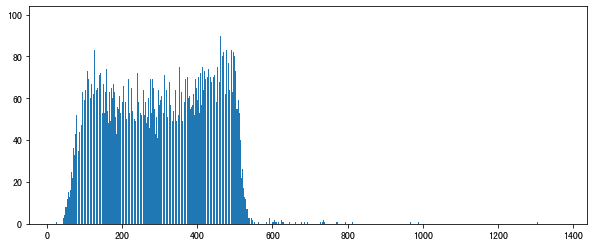

In [76]:
plt.figure(figsize=(10, 4))
plt.bar(list(cnt.keys()), list(cnt.values()))

In [77]:
text = [item for item in text if 5 < len(item) < 1000]
len(text)
# len([item for item in text if 5 < len(item) < 300])

27966

## Clean

In [78]:
def remove_urls (vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

text = [remove_urls(item) for item in tqdm(text)]

text = [re.sub(r'[^\w\s]',' ', item) for item in tqdm(text)]
# text = [item.replace('\\', '').replace('<b>', '').replace('</b>', '').replace('#', '') for item in text]
text[:10]

100%|██████████| 27966/27966 [00:00<00:00, 121493.19it/s]


['JVC  Victor Company of Japan Ltd   日本ビクター株式会社 Nippon Bikutā Kabushiki gaisha   TYO  6792 usually referred to as JVC is a Japanese international consumer and professional electronics corporation based in Yokohama Japan  Founded in 1927 the company is best known for introducing Japan s first televisions and for developing the Video Home System   VHS   video recorder  In 2008 JVC merged with Kenwood Corporation to create JVC Kenwood Holdings ',
 'Daum Communications  Daum   Korean  다음  KRX  035720   is a web portal in South Korea like Naver and Nate  Daum offers many Internet services to web users including a popular free web based e mail messaging service forums shopping and news  The word daum is 多音 means many sounds in Korean The popularity of Daum stems from the range of services it offers but also from the fact that it was the first Korean web portal of significant size ',
 'Lilliput Lane  Lilliput Lane founded in 1982 by David Tate is a company known for its extensive range of rea

### NLTK POS-tag

#### nltk tokenizer

In [79]:
with open('data/en_names.txt', 'r') as fin:
    en_names = list(map(lambda x: x.replace('\n', ''), fin.readlines()))

en_names = [item for item in en_names if item not in label_names]
weeks = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday', 
         'January','February','March','April','May','June','July','August','September','October','November','December']

address = ["Birmingham", "Montgomery", "Mobile", "Anniston", "Gadsden", "Phoenix", "Scottsdale", "Tempe", "Buckeye", "Chandler", "ElDorado", "Jonesboro", "PaineBluff", "LittleRock", "Fayetteville", "FortSmith", "MileHouse", "Kelowna", "PrinceGeorge", "Modesto", "LosAngeles", "Monterey", "SanJose", "SanFrancisco", "Oakland", "Berkeley", "WalnutCreek", "Alturas", "Chico", "Reading", "Fresno", "Norwalk", "Downey", "LongBeach", "SanDiego", "Burbank", "Glendale", "SouthPasadena", "Arcadia", "LosAltos", "PaloAlto", "SouthSanFrancisco", "Eureka", "SantaRosa", "Sonoma", "Anaheim", "Barstow", "PalmSprings", "Bakersfield", "SantaBarbara", "Ventura", "NorthHollywood", "SanFernando", "Salinas", "SolanaBeach", "Riverside", "SanBernardino", "Sacramento", "Pleasanton", "Irvine", "Laguna", "Niguel", "ColoradoSprings", "Pueblo", "Boulder", "Denver", "Aspen", "FortCollins", "GrandJunction", "Bridgeport", "NewHaven", "Hartford", "KeyWest", "Kissimmee", "Gainesville", "Orlando", "BocaRaton", "Sebastian", "WestPalmBeach", "Clearwater", "NorthMiami", "St.Petersburg", "Tampa", "PanamaCity", "Pensacola", "Tallahassee", "AvonPark", "Jacksonville", "FortMyers", "Naples", "Sarasota", "FortLauderdale", "Americus", "Bainbridge", "Valdosta", "WarnerRobins", "Atlanta", "Alpharetta", "Augusta", "Rome", "Atlantasuburbs", "Brunswick", "Macon", "Savannah", "Waycross", "Champaign-Urbana", "Peoria", "RockIsland", "Alton", "Cairo", "EastSt.Louis", "Aurora", "Naperville", "OakBrookTerrace", "Chicagosuburbs", "Joliet", "LaSalle", "Rockford", "Chicago", "Evanston", "Waukegan", "FortWayne", "Gary", "Hammond", "SouthBend", "Indianapolis", "Kokomo", "Evansville", "TerreHaute", "CedarRapids", "Davenport", "Dubuque", "Waterloo", "Ames", "DesMoines", "FortDodge", "Creston", "MasonCity", "CouncilBluffs", "SiouxCity", "Coolidge", "DodgeCity", "Hutchinson", "Wichita", "Topeka", "Manhattan", "Colby", "Goodland", "Lawrence", "Salina", "Hopkinsville", "Owensboro", "Frankfort", "Louisville", "Morehead", "Lexington", "Jellico", "Kensee", "Lot", "Oneida", "Saxton", "BatonRouge", "NewRoads", "Shreveport", "LakeCharles", "Lafayette", "Houma", "NewOrleans", "Cumberland", "Frederick", "Hagerstown", "Annapolis", "Baltimore", "Rockville", "Salisbury", "Pittsfield", "Hyannis", "NewBedford", "Worcester", "Boston", "Norwood", "Weymouth", "Fitchburg", "Methuen", "Peabody", "TraverseCity", "Ludington", "Muskegon", "Detroit", "Lansing", "MountPleasant", "BattleCreek", "Kalamazoo", "AnnArbor", "Monroe", "Flint", "NorthernDetroitsuburbs", "Marquette", "SaultSte.Marie", "Duluth", "GrandRapids", "Moorhead", "StCloud", "Mankato", "Minneapolis", "SaintPaul", "RedWing", "MapleGrove", "Bloomington", "Gulfport", "Pascagoula", "Meriden", "Hattiesburg", "HollySprings", "Tupelo", "StCharles", "StLouis", "Union", "Joplin", "Nevada", "Hannibal", "JeffersonCity", "Independence", "KansasCity", "StJoseph", "GrandIsland", "NorthPlatte", "Scottsbluff", "Hastings", "Lincoln", "Omaha", "O'Neill", "LasVegas", "CarsonCity", "Reno", "Ely", "Hackensack", "Hoboken", "JerseyCity", "AtlanticCity", "Camden", "Trenton", "LongBranch", "NewBrunswick", "Vineland", "CherryHill", "Elizabeth", "Phillipsburg", "Washington", "Newark", "Paterson", "NewYorkCity", "Oswego", "Syracuse", "Utica", "Watertown", "Brentwood", "Hempstead", "Albany", "Gloversville", "Schenectady", "Troy", "Binghamton", "Elmira", "Endicott", "Ithaca", "LongIsland", "Manorville", "Buffalo", "NiagaraFalls", "Rochester", "Bronx", "Brooklyn", "Queens", "StatenIsland", "Flushing", "Poughkeepsie", "Peekskill", "WhitePlains", "Yonkers", "LabradorCity", "St.John's", "AtlanticBeach", "Hatteras", "Asheboro", "Thomasville", "Charlotte", "Concord", "Asheville", "Antioch", "Hickory", "Greensboro", "Winston-Salem", "Durham", "Raleigh", "Waterville", "Whitehorse", "Pangnirtung", "Cleveland", "Akron", "Canton", "Warren", "Youngstown", "BowlingGreen", "Findlay", "Lima", "Toledo", "Mentor", "Oberlin", "Westlake", "Cincinnati", "Middletown", "Cambridge", "Dayton", "Hillsboro", "Springfield", "Athens", "Columbus", "Lancaster", "Marietta", "Enid", "OklahomaCity", "Alva", "Ardmore", "Lawton", "McAlester", "Miami", "Muskogee", "Tulsa", "Toronto", "Guelph", "Kitchener", "London", "Windsor", "Barrie", "NorthBay", "SaultSteMarie", "Sudbury", "Dryden", "Kenora", "FortWilliam", "ThunderBay", "Cooksville", "Hamilton", "Mississauga", "Kingston", "Ottawa", "Astoria", "Beaverton", "Ashland", "Bend", "Corvallis", "Eugene", "Pendleton", "Salem", "Portland", "Philadelphia", "Pittsburgh", "Scranton", "Williamsport", "Philadelphiasuburbs", "Allentown", "Harrisburg", "Gettysburg", "NewCastle", "Latrobe", "Uniontown", "Altoona", "Erie", "Johnstown", "Chicoutimi", "Quebec", "Rimouski", "Montreal", "Lloydminster", "Regina", "Saskatoon", "RockHill", "Charleston", "HiltonHeadIsland", "MyrtleBeach", "Florence", "Anderson", "Greenville", "Spartanburg", "Bristol", "Chattanooga", "Nashville", "Knoxville", "Jackson", "Memphis", "UnionCity", "Columbia", "Manchester", "Cookeville", "SanAntonio", "Waco", "DeerPark", "CorpusChristi", "Victoria", "Beaumont", "Galveston", "Austin", "Bellaire", "Pasadena", "Amarillo", "Lubbock", "FortWorth", "DelRio", "Uvalde", "Houston", "Paris", "Sherman", "Texarkana", "Tyler", "Abilene", "ElPaso", "Huntsville", "Lufkin", "Denton", "WichitaFalls", "Brownsville", "McAllen", "Dallas", "Garland", "GrandPrairie", "Irving", "Plano", "Wharton", "SaintGeorge", "Richfield", "Blanding", "Moab", "SaltLakeCity", "Provo", "Ogden", "Blacksburg", "Roanoke", "Staunton", "Winchester", "Alexandria", "Arlington", "Fairfax", "Herndon", "Norfolk", "NewportNews", "Williamsburg", "Charlottesville", "Danville", "Richmond", "Seattle", "Auburn", "Kent", "Tacoma", "Bellingham", "Olympia", "Vancouver", "Bellevue", "Edmonds", "Everett", "Spokane", "WallaWalla", "Yakima", "WestBend", "Kenosha", "Milwaukee", "Racine", "Beloit", "LaCrosse", "Madison", "Platteville", "EauClaire", "Superior", "Wausau", "GreenBay"]

weeks = [item.lower() for item in weeks]
address = [item.lower() for item in address]

# nltk Tokenizer方法
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

tokenizer = RegexpTokenizer(r'\w+')

tweet = TweetTokenizer()

ps = nltk.PorterStemmer()


weeks = [item.lower() for item in weeks]


def is_en(s):
    for uchar in s:
        if ( uchar >= u'\u0041' and uchar <= u'\u005A' ) or ( uchar >= u'\u0061' and uchar <= u'\u007A'):
            continue
        else:
            return False
    return True



In [80]:
def get_nouns(x):
    nouns = []
    for t in tqdm(x):

        tokens = tweet.tokenize(t)
        pos_tags = nltk.pos_tag(tokens)

        noun = set()
        for word, pos in pos_tags:
            word = word.lower()
            if len(word) > 30 or len(word) < 3: continue
#             if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' ) \
            if (pos == 'NN' or pos == 'NNP' or pos == 'VBN' or pos == 'NNS' or pos == 'NNPS' or pos == 'VBN' or pos == 'JJ' or pos == 'JJS') \
            and word not in stopwords.words('english') \
            and word not in weeks \
            and word not in address \
            and word not in en_names \
            and is_en(word):
                noun.add(word)
#                 noun.add(wnl.lemmatize(word.lower()))
        nouns.append(list(noun))

    return nouns


nouns = process_data(text, get_nouns, num_workers=26)

100%|██████████| 1076/1076 [00:34<00:00, 31.18it/s]


In [81]:
gc()

In [82]:
[' '.join(item) for item in nouns[:10]]

['kenwood video nippon holdings referred international gaisha professional system consumer corporation yokohama jvc vhs japan based ltd recorder company known kabushiki japanese televisions electronics',
 'services korean forums popular korea significant internet communications users based news naver shopping mail fact service size krx many popularity',
 'bothies extensive lilliput cottages models company handmade known cumbria seen miniature based realistic fisherman scenes penrith countries produced',
 'products located company smucker manufacturer toppings spreads american beverages peanut orrville ohio headquarters cream',
 'perret automobile district company known bollack cie netter levallois',
 'built yachtbau builder bavaria giebelstadt principles yacht yachts gmbh production model sailing headquarters',
 'services gatwick headquarters travel islands airlines airline united caribbean greece owned monarch group midlands egypt additional destinations based cyprus mediterranean air

In [83]:
nouns = [item for item in nouns if 5 <= len(item)]
len(nouns)

25835

In [120]:
def freq_filter(data, min_freq=1):
    """
    过滤低频词
    """
    cnter = dict(Counter(list(chain.from_iterable(data))))
    cnter = {k: cnter[k] for k in sorted(cnter, key=lambda x: cnter[x], reverse=True) if cnter[k] > min_freq or k in label_names}
    return set(cnter.keys())


all_words = freq_filter(nouns, min_freq=50)
print(len(all_words))

1026


In [121]:
list(all_words)[:100]

['jewish',
 'alps',
 'regions',
 'global',
 'telugu',
 'memorial',
 'second',
 'university',
 'snail',
 'professor',
 'colonial',
 'multiple',
 'campuses',
 'score',
 'studios',
 'volume',
 'site',
 'social',
 'skyscraper',
 'hospital',
 'illinois',
 'navy',
 'produced',
 'use',
 'territory',
 'one',
 'recognized',
 'tokyo',
 'hms',
 'reservoir',
 'industrial',
 'conference',
 'parents',
 'hit',
 'tennessee',
 'communications',
 'headquartered',
 'language',
 'website',
 'chairman',
 'party',
 'rear',
 'investment',
 'preparatory',
 'release',
 'congo',
 'teams',
 'grade',
 'primary',
 'manager',
 'defense',
 'city',
 'owner',
 'comprehensive',
 'service',
 'northeast',
 'raised',
 'fiction',
 'special',
 'comedy',
 'eastern',
 'novel',
 'foreign',
 'hits',
 'compilation',
 'genus',
 'concert',
 'plot',
 'endangered',
 'magazine',
 'unit',
 'latin',
 'literary',
 'sweden',
 'distribution',
 'author',
 'legislative',
 'brother',
 'colombia',
 'operator',
 'ancient',
 'interior',
 'bosni

In [122]:
w2i = {w: i for i, w in enumerate(all_words)}
i2w = {v: k for k, v in w2i.items()}


g_mat = np.zeros([len(all_words), len(all_words)])

graphs = []

for noun in tqdm(nouns):
    for u in noun:
        for v in noun:
            if not w2i.get(u) or not w2i.get(v): continue
            if u == v: continue
            g_mat[w2i[u], w2i[v]] += 1
            g_mat[w2i[v], w2i[u]] += 1

print(f'graph size in mem: {g_mat.size / 1024 / 1024 / 1024}')

100%|██████████| 25835/25835 [00:03<00:00, 8218.41it/s] 

graph size in mem: 0.0009803809225559235


In [123]:
g_nx = nx.from_numpy_array(g_mat)


print('graph sampling...')
from node2vec import Node2Vec
node2vec = Node2Vec(g_nx, dimensions=16, walk_length=16, num_walks=40, p=1.4, q=1.6)

graph sampling...


Generating walks (CPU: 1): 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


In [124]:
model = node2vec.fit(window=9, min_count=1)

In [126]:
cate_sims = {}
for ln in label_names:
    print(ln)
    
    ws = []
    if w2i.get(ln) == None: continue
    for i, j in model.wv.most_similar(str(w2i[ln]), topn=10000):
        if j < 0.7: continue
        ws.append([i2w[int(i)], j])
        print(i2w[int(i)], j)
    print('-' * 40)
    cate_sims[ln] = ws

company
corporation 0.9601399302482605
inc 0.954104483127594
ltd 0.9501482844352722
owned 0.9353868961334229
systems 0.9297789335250854
software 0.9296708703041077
subsidiary 0.9295699000358582
global 0.9139055609703064
products 0.913793683052063
headquartered 0.9124624133110046
markets 0.9092072248458862
equipment 0.9089046120643616
venture 0.9078860878944397
industries 0.907792329788208
companies 0.9042961001396179
product 0.896612823009491
operations 0.8961936235427856
employees 0.8959784507751465
corporate 0.8928089737892151
manufacturing 0.8924184441566467
network 0.8916212916374207
services 0.8899234533309937
market 0.8881134986877441
support 0.8859262466430664
manufacturer 0.8836780190467834
netherlands 0.8799975514411926
financial 0.8799871206283569
operator 0.8778930306434631
headquarters 0.8745233416557312
enterprise 0.8743278980255127
firm 0.8732262849807739
investment 0.8718619346618652
provider 0.8708875179290771
based 0.8633885979652405
internet 0.8622853755950928
stores 

In [127]:
with open('dbpedia_n2v_cate_sims_v4.pkl', 'wb') as fout:
	pkl.dump(cate_sims, fout)

In [114]:
cate_sims['athlete']

[['championships', 0.9564222097396851],
 ['medal', 0.9494150876998901],
 ['olympic', 0.9484480023384094],
 ['medals', 0.9480361938476562],
 ['olympics', 0.943534791469574],
 ['swimmer', 0.9338947534561157],
 ['bronze', 0.9207362532615662],
 ['event', 0.9178128242492676],
 ['men', 0.9164880514144897],
 ['cup', 0.9082764387130737],
 ['volleyball', 0.9055658578872681],
 ['competitions', 0.8983328938484192],
 ['championship', 0.8972830772399902],
 ['team', 0.891109049320221],
 ['games', 0.8908580541610718],
 ['wrestler', 0.8867471814155579],
 ['trained', 0.8795812129974365],
 ['teams', 0.8788560032844543],
 ['matches', 0.8763710260391235],
 ['wrestling', 0.874459981918335],
 ['medalist', 0.8686925172805786],
 ['competed', 0.8676915764808655],
 ['youth', 0.8653538823127747],
 ['competition', 0.8635143637657166],
 ['skater', 0.8634663224220276],
 ['tournament', 0.8613994717597961],
 ['women', 0.8534757494926453],
 ['caps', 0.8500930666923523],
 ['goalkeeper', 0.8349204063415527],
 ['club', 0

In [113]:
cate_sims['village']

[['population', 0.9727750420570374],
 ['district', 0.9537453651428223],
 ['county', 0.9504018425941467],
 ['hormozgan', 0.9384074211120605],
 ['province', 0.9359081387519836],
 ['sistan', 0.9358237385749817],
 ['census', 0.9356353878974915],
 ['khorasan', 0.9350600242614746],
 ['kermanshah', 0.9323537349700928],
 ['baluchestan', 0.9294021129608154],
 ['khuzestan', 0.9286568760871887],
 ['sofla', 0.9279546737670898],
 ['rural', 0.9236939549446106],
 ['sharqi', 0.9223582148551941],
 ['gharbi', 0.922177791595459],
 ['families', 0.9212856888771057],
 ['mazandaran', 0.920566737651825],
 ['fars', 0.920409083366394],
 ['gilan', 0.9169124960899353],
 ['iran', 0.9163218140602112],
 ['masovian', 0.910686194896698],
 ['howmeh', 0.9105743169784546],
 ['kerman', 0.9014099836349487],
 ['kielce', 0.9008663296699524],
 ['commune', 0.8995359539985657],
 ['warsaw', 0.8983688354492188],
 ['lorestan', 0.8979930877685547],
 ['azerbaijan', 0.8951394557952881],
 ['jonubi', 0.8932701945304871],
 ['reported', 

关键词抽取

In [67]:
import yake

In [84]:
kw_extractor = yake.KeywordExtractor()
language = "en"
max_ngram_size = 1 #最大关键词语长度
deduplication_threshold = 0.9 #设置在关键词中是否可以重复单词
numOfKeywords = 20 
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text[1])
keywords

[('manufacturers', 0.15831692877998726),
 ('major', 0.29736558256021506),
 ('part', 0.29736558256021506),
 ('output', 0.29736558256021506),
 ('sub-contract', 0.29736558256021506),
 ('motor', 0.29736558256021506),
 ('vehicle', 0.29736558256021506)]

In [86]:
nouns[1]

['motor', 'output', 'vehicle', 'part', 'subcontract']

In [85]:
text[1]

'A major part of their output was under sub-contract to motor vehicle manufacturers.'

In [81]:
nouns[0]

['abbott', 'coachbuilding', 'business', 'name', 'trading']

In [220]:
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer  

vectorizer=CountVectorizer()         #该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频  
transformer=TfidfTransformer()       #该类会统计每个词语的tf-idf权值  
X=vectorizer.fit_transform([' '.join(item) for item in nouns])   #将文本转为词频矩阵
tfidf=transformer.fit_transform(X)   #计算tf-idf， 

all_tfidf_words = vectorizer.get_feature_names()

* 词频统计

In [50]:
cnt = {}

for noun in tqdm(nouns):
    for word in noun:
        if not cnt.get(word):
            cnt[word] = 1
        else:
            cnt[word] += 1

100%|██████████| 141887/141887 [00:00<00:00, 316670.97it/s]


In [51]:
word_freq = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}
word_freq

{'district': 10186,
 'film': 9783,
 'village': 9219,
 'county': 9150,
 'school': 7443,
 'album': 7409,
 'family': 6848,
 'company': 5426,
 'river': 4660,
 'university': 4339,
 'province': 4272,
 'member': 4207,
 'state': 4139,
 'city': 4065,
 'world': 3975,
 'part': 3945,
 'name': 3853,
 'house': 3762,
 'college': 3254,
 'war': 3109,
 'iran': 3010,
 'band': 2987,
 'music': 2901,
 'politician': 2805,
 'genus': 2800,
 'plant': 2714,
 'poland': 2669,
 'book': 2647,
 'york': 2602,
 'series': 2527,
 'group': 2510,
 'john': 2510,
 'voivodeship': 2413,
 'studio': 2375,
 'football': 2317,
 'gmina': 2316,
 'novel': 2295,
 'building': 2267,
 'mountain': 2259,
 'area': 2231,
 'church': 2099,
 'league': 2089,
 'player': 2064,
 'rock': 2032,
 'lake': 1978,
 'california': 1939,
 'story': 1849,
 'west': 1797,
 'capital': 1778,
 'singer': 1751,
 'ship': 1732,
 'sea': 1717,
 'south': 1680,
 'england': 1646,
 'service': 1637,
 'india': 1624,
 'class': 1577,
 'debut': 1556,
 'tributary': 1551,
 'science'

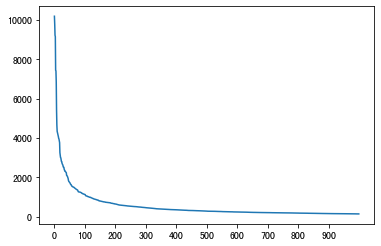

In [52]:
# p = plt.bar(list(word_freq.keys())[:10000], list(word_freq.values())[:10000])

plt.xticks(list(range(0, 1000, 100)))
plt.plot(list(range(0, 1000)), list(word_freq.values())[:1000])

In [53]:
hot_words = list(word_freq.keys())[:300]
hot_words = set(hot_words).difference(label_names)
len(hot_words)

284

In [89]:
nouns = [[jtem for jtem in item if jtem not in hot_words] for item in tqdm(nouns)]

100%|██████████| 1364323/1364323 [00:05<00:00, 270955.23it/s]


In [59]:
# with open('cate_dic.txt', 'r', encoding='utf8') as fin:
#     content = fin.readlines()[0]
# all_cate_dic = eval(content)


In [79]:
nouns = [[jtem for jtem in item if jtem not in inter_words]  for item in tqdm(nouns)]

100%|██████████| 141887/141887 [00:20<00:00, 6774.31it/s]


In [80]:
[' '.join(item) for item in nouns[:10]]

['lausanne imprint houseit rolex',
 'adventist',
 'adventist protestant provider notforprofit churchas healthcare',
 'omg',
 'reggaeton amongst bachata strategy',
 'denny swofford cavity',
 'elliott fontaine sequence acid krebs helio',
 'イオングループ aeon gurūpu ion æon chiba',
 'jusco',
 'company discount target']

In [82]:
film_text = [item for item in nouns if 'athlete' in item]
print(len(film_text))
film_text[:10]

105


[['marcin', 'sadek', 'snatch', 'contribution', 'cord', 'athlete', 'vader'],
 ['shauna', 'derby', 'athlete', 'roller'],
 ['endurance', 'ragsdale', 'athlete'],
 ['athlete', 'roller'],
 ['thamke', 'company', 'athlete', 'anjana'],
 ['medellín', 'archery', 'martínez', 'rendón', 'athlete'],
 ['vladislav',
  'фролов',
  'юрьевич',
  'frolov',
  'athlete',
  'sprint',
  'владислав'],
 ['marianne', 'brussel', 'f1011', 'athlete', 'eventsmarianne', 'javelin'],
 ['middledistance', 't36', 'shvetcov', 'evgenii', 'athlete', 'sprint'],
 ['t46', 'samir', 'athlete', 'eventshe']]

In [83]:
film_text = [item for item in nouns if 'athlete' in item and 'film' in item]
print(len(film_text))
film_text[:10]

2


[['hanja',
  'film',
  'gukgadaepyo',
  '國家代表',
  'kukkataepyohangul',
  'yonghwa',
  '국가대표',
  'athlete'],
 ['film', 'athlete', 'allamerican', 'thorpe', 'teamsthe', 'curtiz']]

In [138]:
# cate_words['athlete']

In [17]:
# abnormal_words = []
# for i, noun in enumerate(tqdm(nouns)):
#     nouns[i] = [word if len(wordnet.synsets(word)) > 0 else abnormal_words.append(word) for word in noun ]

In [18]:
# abnormal_words

# 构图

In [635]:
# G = nx.Graph()

# all_words = set()
# for noun in tqdm(nouns):
#     for i, ni in enumerate(noun):
#         all_words.add(ni)
#         for j, nj in enumerate(list(noun)[i:]):
#             if i == j: continue
                
#             all_words.add(nj)

#             u = list(all_words).index(ni)
#             v = list(all_words).index(nj)
            
#             G.add_node(u)
#             G.add_node(v)
#             G.add_edge(u, v)


In [84]:
def freq_filter(data, min_freq=1, max_freq=1.):
    """
    过滤低频词
    """
    cnter = dict(Counter(list(chain.from_iterable(data))))
    cnter = {k: cnter[k] for k in sorted(cnter, key=lambda x: cnter[x], reverse=True) if cnter[k] > min_freq and cnter[k] / len(data) < max_freq}
    return set(cnter.keys())

In [85]:
all_words = freq_filter(nouns, min_freq=5)
len(all_words)

13518

In [86]:
all_words

{'chrzanów',
 'japanit',
 'outlet',
 'sligo',
 'québécois',
 'ortler',
 'felice',
 'preproduction',
 'submission',
 'centurion',
 'khanna',
 'fonda',
 'schifrin',
 'nino',
 'clipper',
 'escape',
 'mahila',
 'phylogeny',
 'dung',
 'partyhe',
 'sporting',
 'camii',
 'foy',
 'mallee',
 'marist',
 'chisholm',
 'fragrance',
 'wax',
 'apollo',
 'qoli',
 'maple',
 'grape',
 'couldnt',
 'reliance',
 'attraction',
 'talbot',
 'tomentosa',
 'fairfield',
 'cramp',
 'exwife',
 'antoine',
 'jewish',
 'strei',
 'sheriff',
 'trybunalski',
 'bag',
 'gearbox',
 'patience',
 'spa',
 'marketer',
 'councilor',
 'norte',
 'spice',
 'brookline',
 'torus',
 'trafalgar',
 'soy',
 'sent',
 'table',
 'compact',
 'rawska',
 'quo',
 'handball',
 'kebangsaan',
 'brasileiro',
 'mediterranean',
 'górka',
 'cardona',
 'laurier',
 'patterson',
 'yarmouth',
 'aluminum',
 'mistress',
 'vidya',
 'wild',
 'مهدي',
 'voc',
 'orpheus',
 'schultz',
 'xavier',
 'reelection',
 'checklist',
 'vítor',
 'conclusion',
 'sedgwick',


In [87]:
w2i = {w: i for i, w in enumerate(all_words)}
i2w = {v: k for k, v in w2i.items()}

In [88]:
g_mat = np.zeros([len(all_words), len(all_words)])
g_mat.shape

(13518, 13518)

In [89]:
print(f'graph size in mem: {g_mat.size / 1024 / 1024 / 1024}')

graph size in mem: 0.17018646374344826


In [90]:
graphs = []

win = 10

for noun in tqdm(nouns):
    for u in noun:
        noun = noun
        mid_idx = noun.index(u)
        for v in noun[max(0, mid_idx - win): min(len(noun), mid_idx + win)]:
            if not w2i.get(u) or not w2i.get(v): continue
            if u == v: continue
            g_mat[w2i[u], w2i[v]] += 1
#             g_mat[w2i[v], w2i[u]] += 1

100%|██████████| 141887/141887 [00:02<00:00, 64104.74it/s]


In [74]:
# with open('cached/graph_ndarray.bin', 'wb') as fout:
#     pkl.dump(g_mat, fout)

## build graph

### pagerank

networkx

In [91]:
g_nx = nx.from_numpy_array(g_mat)
g = nx.DiGraph(g_nx)

In [92]:
N = len(g_mat)
DAMP = 0.85
N, DAMP
pr = nx.pagerank(g, alpha=DAMP)

In [95]:
# 用1-hop的pv作为排序
cate_words = {}
for ln in label_names:
    cate_words.setdefault(ln, [])
    try:
        adjoin_nodes = [idx for idx, val in enumerate(g_mat[w2i[ln]]) if val != 0]
        print(f'"{ln}" has {len(adjoin_nodes)} adjoin nodes.')

        top_idxs = torch.topk(torch.FloatTensor(list(pr.values()))[adjoin_nodes], 100)[1]
#         top_idxs = torch.topk(g.ndata['pv'][adjoin_nodes], np.sum(np.array(adjoin_nodes) > 0))[1]

        words = []
        for idx in top_idxs:
            words.append(i2w[adjoin_nodes[idx.item()]])

        cate_words[ln].extend(words)
    except Exception as e:
        print(e)
        print(ln)

"company" has 3959 adjoin nodes.
"school" has 3780 adjoin nodes.
"university" has 2808 adjoin nodes.
"artist" has 1309 adjoin nodes.
"athlete" has 172 adjoin nodes.
"government" has 1168 adjoin nodes.
"transportation" has 247 adjoin nodes.
"building" has 1542 adjoin nodes.
"river" has 2265 adjoin nodes.
"mountain" has 1508 adjoin nodes.
"lake" has 1308 adjoin nodes.
"village" has 2147 adjoin nodes.
"animal" has 83 adjoin nodes.
selected index k out of range
animal
"plant" has 1429 adjoin nodes.
"tree" has 633 adjoin nodes.
"album" has 3785 adjoin nodes.
"film" has 5692 adjoin nodes.
"novel" has 2235 adjoin nodes.
"publication" has 356 adjoin nodes.
"book" has 2599 adjoin nodes.


In [96]:
cate_words

{'company': ['film',
  'village',
  'album',
  'school',
  'river',
  'university',
  'book',
  'plant',
  'novel',
  'voivodeship',
  'mountain',
  'building',
  'lake',
  'artist',
  'government',
  'tree',
  'engine',
  'compilation',
  'destroyer',
  'hockey',
  'rugby',
  'constituency',
  'defender',
  'feed',
  'fleet',
  'cargo',
  'shipbuilding',
  'vocalist',
  'moth',
  'duo',
  'soundtrack',
  'publication',
  'frame',
  'draft',
  'escort',
  'bollywood',
  'locomotive',
  'kumar',
  'monoplane',
  'senator',
  'provider',
  'lublin',
  'roof',
  'cultivar',
  'frigate',
  'loan',
  'bosnia',
  'transportation',
  'bolivia',
  'biplane',
  'billboard',
  'nfl',
  'herzegovina',
  'speed',
  'bassist',
  'general',
  'motorcycle',
  'cruiser',
  'pitcher',
  'glacier',
  'chart',
  'luxury',
  'tennis',
  'uboat',
  'return',
  'australian',
  'consumer',
  'rate',
  'enrollment',
  'liner',
  'paperback',
  'flagship',
  'sabha',
  'twoseat',
  'glider',
  'jet',
  'anthol

In [58]:
with open('cate_dic.txt', 'w') as fout:
    fout.writelines(str(cate_words))

In [74]:
intersection = set()
cnt = Counter(list(chain.from_iterable(list(cate_words.values()))))
cnt = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}
print(len(cnt))
cnt

6775


{'county': 15,
 'family': 15,
 'city': 15,
 'part': 15,
 'world': 15,
 'member': 15,
 'name': 15,
 'state': 15,
 'house': 15,
 'war': 15,
 'college': 15,
 'band': 15,
 'john': 15,
 'york': 15,
 'group': 15,
 'series': 15,
 'poland': 15,
 'area': 15,
 'california': 15,
 'rock': 15,
 'west': 15,
 'capital': 15,
 'service': 15,
 'south': 15,
 'science': 15,
 'england': 15,
 'time': 15,
 'street': 15,
 'canada': 15,
 'career': 15,
 'range': 15,
 'year': 15,
 'park': 15,
 'home': 15,
 'germany': 15,
 'development': 15,
 'george': 15,
 'island': 15,
 'community': 15,
 'country': 15,
 'william': 15,
 'road': 15,
 'history': 15,
 'america': 15,
 'union': 15,
 'number': 15,
 'japan': 15,
 'art': 15,
 'research': 15,
 'production': 15,
 'pennsylvania': 15,
 'washington': 15,
 'design': 15,
 'corporation': 15,
 'coast': 15,
 'side': 15,
 'system': 15,
 'magazine': 15,
 'texas': 15,
 'line': 15,
 'massachusetts': 15,
 'death': 15,
 'robert': 15,
 'day': 15,
 'summer': 15,
 'award': 15,
 'water': 1

In [78]:
inter_words = [k for k, v in cnt.items() if v > 6 and k not in label_names]
print(len(inter_words))
inter_words

1880


['county',
 'family',
 'city',
 'part',
 'world',
 'member',
 'name',
 'state',
 'house',
 'war',
 'college',
 'band',
 'john',
 'york',
 'group',
 'series',
 'poland',
 'area',
 'california',
 'rock',
 'west',
 'capital',
 'service',
 'south',
 'science',
 'england',
 'time',
 'street',
 'canada',
 'career',
 'range',
 'year',
 'park',
 'home',
 'germany',
 'development',
 'george',
 'island',
 'community',
 'country',
 'william',
 'road',
 'history',
 'america',
 'union',
 'number',
 'japan',
 'art',
 'research',
 'production',
 'pennsylvania',
 'washington',
 'design',
 'corporation',
 'coast',
 'side',
 'system',
 'magazine',
 'texas',
 'line',
 'massachusetts',
 'death',
 'robert',
 'day',
 'summer',
 'award',
 'water',
 'hill',
 'virginia',
 'car',
 'inc',
 'department',
 'place',
 'engineering',
 'site',
 'kingdom',
 'ontario',
 'division',
 'joseph',
 'border',
 'henry',
 'australia',
 'power',
 'mexico',
 'land',
 'point',
 'pinyin',
 'saint',
 'gold',
 'industry',
 'ireland',

DGL

In [42]:
g = dgl.DGLGraph(g_nx)
g

Graph(num_nodes=38732, num_edges=7150186,
      ndata_schemes={}
      edata_schemes={})

In [43]:
# with open('cached/graph_dgl.bin', 'wb') as fout:
#     pkl.dump(g, fout)

In [44]:
N = len(g_mat)
DAMP = 0.85
N, DAMP

(38732, 0.85)

In [46]:
def pagerank(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    
    g.update_all(message_func=fn.copy_src(src='pv', out='m'), 
                 reduce_func=fn.sum(msg='m', out='m_sum'))
    
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [47]:
g.ndata['pv'] = torch.ones(N) / N
# g.ndata['pv'] = torch.rand(N) / N

g.ndata['deg'] = g.out_degrees(g.nodes()).float()

for i in tqdm(range(100)):
    pagerank(g)

100%|██████████| 100/100 [00:00<00:00, 487.31it/s]


In [48]:
g.ndata['pv']

tensor([3.8728e-06, 5.9779e-06, 1.3985e-05,  ..., 1.6379e-05, 4.7658e-05,
        1.1681e-05])

* government
* sport
* business
* technology


In [49]:
# 用1-hop的pv作为排序
cate_words = {}
for ln in label_names:
    cate_words.setdefault(ln, [])
    try:
        adjoin_nodes = [idx for idx, val in enumerate(g_mat[w2i[ln]]) if val != 0]
        print(f'"{ln}" has {len(adjoin_nodes)} adjoin nodes.')

        top_idxs = torch.topk(g.ndata['pv'][adjoin_nodes], 100)[1]

        words = []
        for idx in top_idxs:
            words.append(i2w[adjoin_nodes[idx.item()]])

        cate_words[ln].extend(words)
    except:
        print(ln)

"company" has 9771 adjoin nodes.
"school" has 13136 adjoin nodes.
"university" has 9862 adjoin nodes.
"artist" has 6028 adjoin nodes.
"athlete" has 953 adjoin nodes.
"government" has 4456 adjoin nodes.
"transportation" has 1255 adjoin nodes.
"building" has 5581 adjoin nodes.
"river" has 7938 adjoin nodes.
"mountain" has 6192 adjoin nodes.
"lake" has 4533 adjoin nodes.
"village" has 8080 adjoin nodes.
"animal" has 714 adjoin nodes.
"plant" has 4924 adjoin nodes.
"tree" has 2945 adjoin nodes.
"album" has 10934 adjoin nodes.
"film" has 14533 adjoin nodes.
"novel" has 8155 adjoin nodes.
"publication" has 1674 adjoin nodes.
"book" has 9379 adjoin nodes.


In [50]:
cate_words

{'company': ['name',
  'family',
  'film',
  'school',
  'district',
  'village',
  'part',
  'album',
  'world',
  'university',
  'river',
  'city',
  'series',
  'county',
  'book',
  'july',
  'music',
  'september',
  'genus',
  'member',
  'march',
  'house',
  'war',
  'group',
  'band',
  'december',
  'john',
  'story',
  'novel',
  'studio',
  'state',
  'south',
  'college',
  'june',
  'york',
  'year',
  'debut',
  'mountain',
  'drama',
  'plant',
  'title',
  'april',
  'life',
  'career',
  'time',
  'work',
  'california',
  'service',
  'singer',
  'town',
  'record',
  'west',
  'church',
  'north',
  'artist',
  'building',
  'number',
  'island',
  'rock',
  'league',
  'team',
  'football',
  'area',
  'footballer',
  'writer',
  'george',
  'ship',
  'east',
  'england',
  'author',
  'science',
  'century',
  'lake',
  'road',
  'player',
  'business',
  'august',
  'side',
  'october',
  'education',
  'comedy',
  'class',
  'canada',
  'province',
  'home',
  

In [ ]:
co_occu = set()
for c, words in cate_words.items():
    co_occu

In [95]:
tech_ws = cate_words['technology']
bus_ws = cate_words['business']
sport_ws = cate_words['sport']
poli_ws = cate_words['government']

In [96]:
set(sport_ws).intersection(bus_ws).intersection(tech_ws).intersection(poli_ws)

{'company',
 'friday',
 'group',
 'monday',
 'thursday',
 'time',
 'today',
 'tuesday',
 'week',
 'world',
 'year',
 'yesterday',
 'york'}

In [97]:
set(sport_ws).difference(bus_ws).difference(tech_ws).difference(poli_ws)

{'action',
 'anyone',
 'appeal',
 'arbitration',
 'ban',
 'baseball',
 'basketball',
 'bernie',
 'blood',
 'body',
 'cas',
 'catch',
 'champion',
 'committee',
 'competition',
 'cricket',
 'cup',
 'cycling',
 'decision',
 'doping',
 'drug',
 'ecclestone',
 'effort',
 'event',
 'fishing',
 'football',
 'ford',
 'formula',
 'fox',
 'france',
 'funding',
 'future',
 'game',
 'gold',
 'gymnast',
 'hamilton',
 'hamm',
 'head',
 'hearing',
 'history',
 'hockey',
 'honda',
 'ice',
 'lausanne',
 'league',
 'london',
 'love',
 'matthew',
 'medal',
 'money',
 'montgomery',
 'motor',
 'nascar',
 'nation',
 'night',
 'olympic',
 'paul',
 'pinsent',
 'prix',
 'race',
 'retirement',
 'rugby',
 'safety',
 'scandal',
 'season',
 'series',
 'switzerland',
 'taeyoung',
 'team',
 'television',
 'test',
 'top',
 'use',
 'utility',
 'vehicle',
 'victory',
 'win',
 'yang'}

In [98]:
set(bus_ws).difference(sport_ws).difference(tech_ws).difference(poli_ws)

{'bank',
 'battle',
 'bid',
 'cash',
 'confidence',
 'francisco',
 'insurance',
 'intelligence',
 'investment',
 'lenovo',
 'loss',
 'move',
 'online',
 'oracle',
 'peoplesoft',
 'priority',
 'process',
 'quote',
 'sale',
 'stake',
 'stock',
 'survey',
 'takeover',
 'technology',
 'unit',
 'wire'}

In [99]:
set(tech_ws).difference(bus_ws).difference(sport_ws).difference(poli_ws)

{'acquisition',
 'amd',
 'apple',
 'center',
 'chip',
 'cisco',
 'conference',
 'contract',
 'demand',
 'development',
 'device',
 'dvd',
 'email',
 'engine',
 'google',
 'identification',
 'institute',
 'intel',
 'iran',
 'network',
 'officer',
 'patent',
 'performance',
 'processor',
 'radio',
 'science',
 'sector',
 'semiconductor',
 'sony',
 'space',
 'storage',
 'video',
 'web'}

In [100]:
set(poli_ws).difference(bus_ws).difference(tech_ws).difference(sport_ws)

{'agency',
 'aid',
 'air',
 'ariel',
 'attack',
 'baghdad',
 'bill',
 'city',
 'coalition',
 'conflict',
 'crisis',
 'crude',
 'darfur',
 'department',
 'election',
 'energy',
 'hostage',
 'iraq',
 'iraqi',
 'labor',
 'law',
 'leader',
 'militia',
 'minister',
 'office',
 'opposition',
 'parliament',
 'party',
 'peace',
 'police',
 'press',
 'program',
 'rate',
 'rebel',
 'region',
 'release',
 'secretary',
 'spending',
 'spokesman',
 'strike',
 'sudan',
 'sunday',
 'trade',
 'union',
 'violence',
 'war'}

### GNN

In [5]:
with open('cached/graph_networkx.bin', 'rb') as fin:
    g_nx = pkl.load(fin)

In [39]:
from node2vec import Node2Vec

In [ ]:
node2vec = Node2Vec(g, dimensions=64, walk_length=16, num_walks=20, p=1.3, q=0.8)


Computing transition probabilities:  30%|██▉       | 13402/45408 [4:56:04<9:21:17,  1.05s/it] 

In [ ]:
model = node2vec.fit(window=10, min_count=1)

In [ ]:
with open('node2vec_model.pkl', 'wb') as fout:
    pkl.dump(node2vec, fout)

In [ ]:
cate_sims = {}
for ln in label_names:
    print(ln)
    
    ws = []
    for i, j in model.most_similar(str(w2i[ln]), topn=100):
        ws.append([i2w[int(i)], j])
        print(i2w[int(i)], j)
    print('-' * 40)
    cate_sims[ln] = ws

In [ ]:
model.save('node2vec-model/agnews_noun_n2v_p1.3_q.8_wl16_nw20.bin')

In [ ]:
123

* TextBlob

作为nltk的替代，TextBlob库能够更进一步进行词组划分，例如“computer science”会被当做一个单词，而非"computer"和"science"

In [46]:
# !/chj/conda_store/envs/nlp_task/bin/pip install textblob

In [36]:
from textblob import TextBlob
txt = """Natural language processing (NLP) is a field of computer science, artificial intelligence, and computational linguistics concerned with the inter
actions between computers and human (natural) languages."""
txt = text[0]
blob = TextBlob(txt)
print(type(blob.noun_phrases))
print(list(blob.noun_phrases))

<class 'textblob.blob.WordList'>
['wall', 'claw', 'black', 'reuters', 'reuters', 'short-sellers', 'wall', "street 's"]
